<a href="https://colab.research.google.com/github/gr1nick/lab_bigData/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
banknote_authentication = fetch_ucirepo(id=267)

# data
X = banknote_authentication.data.features
y = banknote_authentication.data.targets


In [ ]:
from sklearn.model_selection import train_test_split


# Проверка на наличие пропущенных значений
missing_values_check = X.isnull().sum()

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

missing_values_check, X_train.shape, X_test.shape
X_train_np = X_train.values
y_train_np = y_train.values
y_test_np = y_test.values
X_test_np = X_test.values


In [ ]:
y_train_np = y_train_np.ravel()
y_test_np = y_test_np.ravel()

In [ ]:
import numpy as np

# Функции потерь
def logistic_loss(y, y_pred):
    """Logistic loss function."""
    return np.log(1 + np.exp(-y * y_pred)).mean()

def adaboost_loss(y, y_pred):
    """Adaboost loss function."""
    return np.exp(-y * y_pred).mean()

def binary_crossentropy(y, y_pred):
    """Binary crossentropy loss function."""
    epsilon = 1e-15  # Для предотвращения деления на ноль
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Корректировка y_pred для предотвращения log(0)
    return (-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)).mean()

# Функция для расчета сигмоиды, используется для предсказания вероятностей
def sigmoid(z):
    return 1 / (1 + np.exp(-z))



In [ ]:
class CustomLogisticRegressionUpdatedFixed:
    def __init__(self, loss_function='logistic', learning_rate=0.01, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.loss_function = loss_function
        self.loss_history = []  # Для хранения истории потерь
        self.val_loss_history = []

    def _loss(self, y, y_pred):
        """Вычисление значения функции потерь."""
        if self.loss_function == 'logistic':
            return logistic_loss(y*2-1, y_pred)
        elif self.loss_function == 'adaboost':
            return adaboost_loss(y*2-1, y_pred)
        elif self.loss_function == 'binary_crossentropy':
            return binary_crossentropy(y, sigmoid(y_pred))
        else:
            raise ValueError("Unsupported loss function.")

    def _loss_derivative(self, y, y_pred):
        """Расчёт производной функции потерь."""
        if self.loss_function == 'logistic':
            return -y * (1 - sigmoid(y * y_pred))
        elif self.loss_function == 'adaboost':
            return -y * np.exp(-y * y_pred)
        elif self.loss_function == 'binary_crossentropy':
            y = y * 2 - 1  # Преобразуем y из {0,1} в {-1,1}
            return -y / (1 + np.exp(y * y_pred))
        else:
            raise ValueError("Unsupported loss function.")

    def fit(self, X, y, X_val=None, y_val=None):
      n_samples, n_features = X.shape
      self.weights = np.zeros(n_features + 1)  # Инициализация весов (4 признака + 1 bias)

      # Добавление столбца для bias
      X_with_bias = np.c_[np.ones((n_samples, 1)), X]

      self.loss_history = []  # Сбрасываем историю потерь
      self.val_loss_history = []  # Добавляем историю потерь для валидационного набора

      for _ in range(self.max_iter):
          # Линейная комбинация признаков и весов
          linear_model = np.dot(X_with_bias, self.weights)
          # Применение сигмоидальной функции для получения вероятностей
          y_pred = sigmoid(linear_model)

          # Расчет производной функции потерь
          derivative_loss = self._loss_derivative(y, linear_model)

          # Расчет градиента как среднего значения производной функции потерь по всем примерам
          gradient = np.dot(X_with_bias.T, derivative_loss) / n_samples

          # Обновление весов
          self.weights -= self.learning_rate * gradient

          # Расчет и добавление значения функции потерь
          loss = self._loss(y, y_pred)
          self.loss_history.append(loss)
          if X_val is not None and y_val is not None:
              val_linear_model = np.dot(np.c_[np.ones((X_val.shape[0], 1)), X_val], self.weights)
              val_y_pred = sigmoid(val_linear_model)
              val_loss = self._loss(y_val, val_y_pred)
              self.val_loss_history.append(val_loss)

      return self.val_loss_history
    def predict_proba(self, X):
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        linear_model = np.dot(X_with_bias, self.weights)
        return sigmoid(linear_model)

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.where(probabilities > 0.5, 1, 0)


In [ ]:
clf_logistic = CustomLogisticRegressionUpdatedFixed(loss_function='logistic', learning_rate=1, max_iter=100)
clf_logistic.fit(X_train_np, y_train_np)
print('logistic: \n', clf_logistic.loss_history[-1])

clf_adaboost = CustomLogisticRegressionUpdatedFixed(loss_function='adaboost', learning_rate=0.2, max_iter=100)
clf_adaboost.fit(X_train_np, y_train_np)
print('adaboost: \n', clf_adaboost.loss_history[-1])

clf_binary = CustomLogisticRegressionUpdatedFixed(loss_function='binary_crossentropy', learning_rate=1, max_iter=100)
clf_binary.fit(X_train_np, y_train_np)
print('binary_crossentropy: \n', clf_binary.loss_history[-1])

logistic: 
 0.6653890113452076
adaboost: 
 1.0804476785752606
binary_crossentropy: 
 0.5365724204607082


In [ ]:
val_losses_logistic = clf_logistic.fit(X_train_np, y_train_np, X_test_np, y_test_np)
val_losses_adaboost = clf_adaboost.fit(X_train_np, y_train_np, X_test_np, y_test_np)
val_losses_binary = clf_binary.fit(X_train_np, y_train_np, X_test_np, y_test_np)


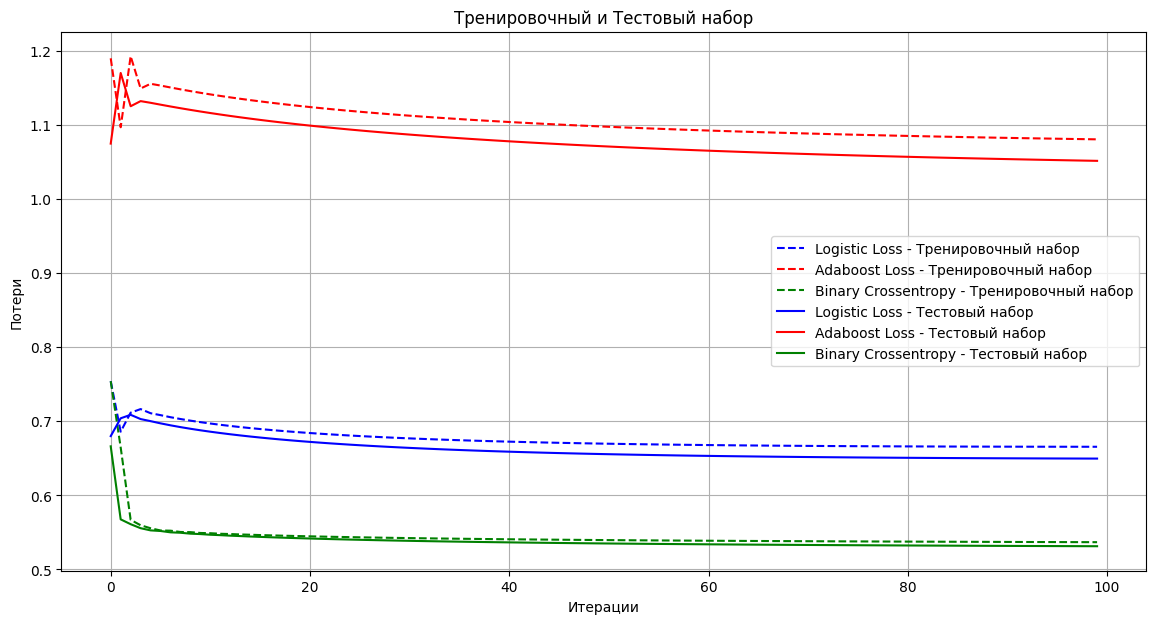

In [ ]:
plt.figure(figsize=(14, 7))

# Тренировочный набор
plt.plot(clf_logistic.loss_history, label='Logistic Loss - Тренировочный набор', color='blue', linestyle='--')
plt.plot(clf_adaboost.loss_history, label='Adaboost Loss - Тренировочный набор', color='red', linestyle='--')
plt.plot(clf_binary.loss_history, label='Binary Crossentropy - Тренировочный набор', color='green', linestyle='--')

# Тестовый набор
plt.plot(val_losses_logistic, label='Logistic Loss - Тестовый набор', color='blue')
plt.plot(val_losses_adaboost, label='Adaboost Loss - Тестовый набор', color='red')
plt.plot(val_losses_binary, label='Binary Crossentropy - Тестовый набор', color='green')

plt.title('Тренировочный и Тестовый набор')
plt.xlabel('Итерации')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Считаем accuracy для каждой модели
accuracy_logistic = accuracy_score(y_test_np, clf_logistic.predict(X_test_np))
accuracy_adaboost = accuracy_score(y_test_np, clf_adaboost.predict(X_test_np))
accuracy_binary = accuracy_score(y_test_np, clf_binary.predict(X_test_np))

# Выводим accuracy для каждой модели
print(f"Accuracy of logistic regression: {accuracy_logistic:.4f}")
print(f"Accuracy of adaboost: {accuracy_adaboost:.4f}")
print(f"Accuracy of binary crossentropy: {accuracy_binary:.4f}")


Accuracy of logistic regression: 0.8073
Accuracy of adaboost: 0.7855
Accuracy of binary crossentropy: 0.9855
